In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater
from causalbenchmark.novo import misc

In [2]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl']).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
@tool('treatments')
def get_treatments(nodes):
    tr = [node for node in nodes if node['type'] == 'treatment']
    assert len(tr) == 2
    return tr
@tool('outcome')
def get_outcome(nodes):
    o = [node for node in nodes if node['type'] == 'outcome']
    assert len(o) == 1
    return o[0]
@tool('confounders')
def get_confounders(nodes):
    c = [node for node in nodes if node['type'] == 'confounder']
    return c

In [4]:
setting_generation_prompt_template = \
'''We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment and outcome variable) and no causal parents
- mediator variables may or may not be observable, and should always have at least one causal parent (for example, a treatment variable) and at least one causal child (for example, the outcome variable)
- collider variables may or may not be observable, and should always have at least two causal parents (for example, a treatment and outcome variable) and no causal children

Answer concisely and precisely in the desired format. Carefully complete each of these tasks in order.

1. Write a short description of what the article is about and what causal model make inform the reasoning behind an argument the might make.
2. Propose 1 outcome variable that the news article is either implicitly or explicitly addressing that people are most likely to be interested in studying, especially if people tend to have misconceptions about it
3. Propose 2 treatment variables that either directly or indirectly affect the selected outcome variable and are the most interesting to study
4. Propose 3 confounder variables that affect some reasonable combination of the outcome and treatment variables
5. Propose 3 mediator variables that affect and are affected by some reasonable combination of any other variables
6. Propose 2 collider variables that are affected by some reasonable combination of any other variables

Here is the beginning of the news article:
```
{spark}
```

The variables and causal graph should, where possible, use specific details such as names and locations mentioned in the article. Also, generally the variable value "0" should correspond to the negative, neutral, or control while the value "1" should correspond to the positive choice or active value.

Take a deep breath and think step-by-step about how you will do this.'''
graph_selection_prompt_template = \
'''1. From all proposed confounder, mediator, and collider variables, select between 4-6 variables that are most interesting to study and together with the treatment and outcome variables result in a realistic interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than TWO parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to the index)
- `parents`: a python list of the names of the parents of the variable (make sure they match the corresponding `name` field of the parent nodes, and remember, there should not be more than TWO parents for any node)

Take a deep breath and think step-by-step about how you will do this.'''
stats_prompt_template = \
'''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

{questions}

Where the variables are defined as:
{descriptions}

For each question above, answer with the lower and upper bound estimates of the probabilities as a python dictionary where the key corresponds to the question index in exactly the following format:

```python
probabilities = {{
  1: [0.3, 0.4],
  ...
}}
```

Answer concisely and precisely in the desired format.'''

In [5]:
ctx = Story(story_root=misc.data_root() / 'stories', story_id='test14')
# ctx = Story(story_root=misc.data_root() / 'stories')
# ctx.populate_defaults()
ctx.include(
    FixedTemplate('setting', setting_generation_prompt_template),
    FixedTemplate('graph', graph_selection_prompt_template),
    StatisticsPrompting(stats_prompt_template),
    spark_generator,
    get_treatments,
    get_outcome,
    get_confounders,
);
# print(ctx)
# ctx['seed'] = 6805333
print(ctx['seed'])
print(ctx['spark'])

6805333
Title: To reduce the risk of heart attack and stroke, 150 grams of these 2 fruits per week could help us - Stock Market Projections
Description: The symbolism associates economic luck and iron health with dried fruit. Especially in Northern European countries, this bond is deeply felt, and not
Original Language: Italian


In [6]:
print(ctx['setting'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired
- confounder variables may or may not be observable, and should always have at least two causal children (for example, a treatment

In [7]:
print(ctx['graph'])

1. From all proposed confounder, mediator, and collider variables, select between 4-6 variables that are most interesting to study and together with the treatment and outcome variables result in a realistic interesting causal graph. Important: Make sure the causal graph is a DAG and that no node has more than TWO parents!
2.  List all the edges in the causal graph, and make sure to mention which edges are observable and which are not.
3. Provide a python list called `nodes` of all the nodes in the proposed graph. For each node, provide the following information in the form of a python dict:
- `name`: the name of the variable
- `description`: a short description of the variable
- `type`: the type of the variable, which can be one of the following: `outcome`, `treatment`, `confounder`, `mediator`, `collider`
- `observed`: a boolean value indicating whether the variable is observable or not
- `values`: a python list of the descriptions of the values the variable can take (corresponding to

In [8]:
#################################################


nodes = [
    {
        "name": "Lifestyle Habits",
        "description": "Individual's general lifestyle habits",
        "type": "confounder",
        "observed": True,
        "values": ["Unhealthy habits", "Healthy habits"],
        "parents": []
    },
    {
        "name": "Health Awareness",
        "description": "Awareness of health-related information and practices",
        "type": "mediator",
        "observed": True,
        "values": ["Low awareness", "High awareness"],
        "parents": ["Lifestyle Habits"]
    },
    {
        "name": "Fruit Consumption",
        "description": "Consumption of fruits weekly",
        "type": "treatment",
        "observed": True,
        "values": ["< 150 grams", ">= 150 grams"],
        "parents": ["Lifestyle Habits", "Health Awareness"]
    },
    {
        "name": "Type of Fruit Consumed",
        "description": "Type of fruits consumed, specified or others",
        "type": "treatment",
        "observed": True,
        "values": ["Other fruits", "Specified fruits"],
        "parents": []
    },
    {
        "name": "Cardiovascular Health",
        "description": "Overall cardiovascular health status",
        "type": "outcome",
        "observed": True,
        "values": ["Poor", "Good"],
        "parents": ["Lifestyle Habits", "Fruit Consumption", "Type of Fruit Consumed"]
    },
    {
        "name": "Perceived Health Status",
        "description": "Individual's perception of their health status",
        "type": "collider",
        "observed": True,
        "values": ["Perceived as Poor", "Perceived as Good"],
        "parents": ["Cardiovascular Health", "Health Awareness"]
    }
]




#################################################
varvals = {node['name']: node['values'] for node in nodes}
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))

ctx['nodes'] = nodes


/tmp/ipykernel_939518/3652574873.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


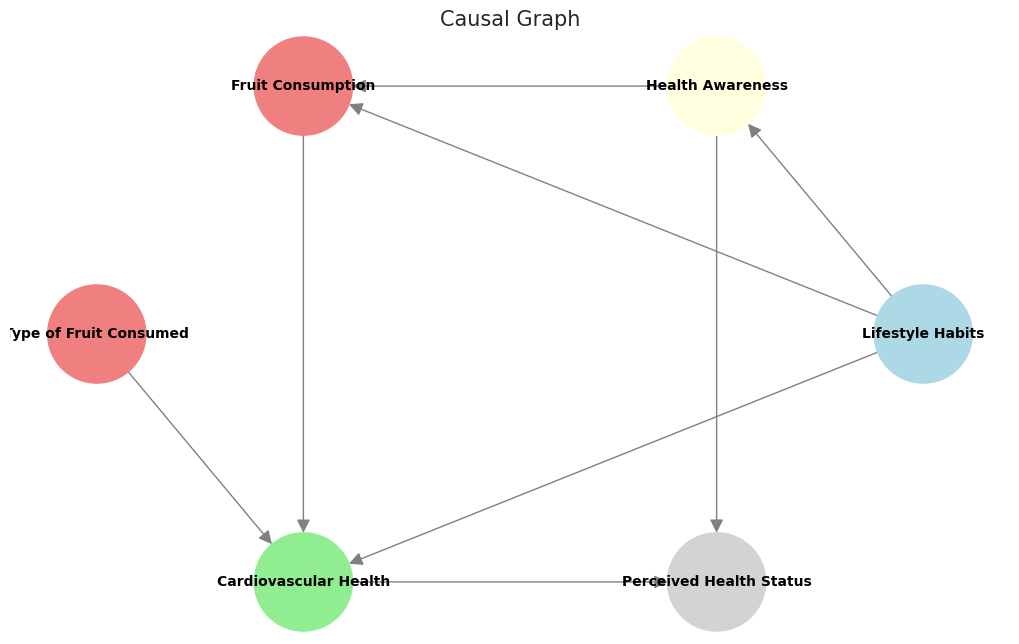

In [9]:
G = nx.DiGraph()

# Add nodes and edges to the graph
for node in ctx['nodes']:
    G.add_node(node['name'], type=node['type'], observed=node['observed'])
    for parent in node['parents']:
        G.add_edge(parent, node['name'])

# Define node colors based on type
node_colors = {'treatment': 'lightcoral', 'outcome': 'lightgreen', 'confounder': 'lightblue', 'mediator': 'lightyellow', 'collider': 'lightgray'}
colors = [node_colors[G.nodes[n]['type']] for n in G.nodes]

# Draw the graph
plt.figure(figsize=(10, 6))
# pos = nx.spring_layout(G)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=5000, font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)
plt.title('Causal Graph', size=15);
plt.tight_layout();

In [10]:
print(ctx['stats'])

We have a causal bayes net based on the following article:

```
Title: To reduce the risk of heart attack and stroke, 150 grams of these 2 fruits per week could help us - Stock Market Projections
Description: The symbolism associates economic luck and iron health with dried fruit. Especially in Northern European countries, this bond is deeply felt, and not
Original Language: Italian
```

Now we would like to estimate the probabilities of certain events.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Lifestyle Habits" is "Healthy habits" (rather than "Unhealthy habits")?
2. when "Lifestyle Habits" is "Unhealthy habits": what is the probability that "Health Awareness" is "High awareness" (rather than "Low awareness")?
3. when "Lifestyle Habits" is "Healthy habits": what is the probability that "Health Awareness" is "High awareness" (rather than "Low awareness")?
4. when "Lifestyle Habits" is "Unhealthy habits" and "Health Awarene

In [11]:
#################################################



probabilities = {
    1: [0.4, 0.6],  # Healthy lifestyle habits in the general population
    2: [0.1, 0.3],  # High health awareness with unhealthy lifestyle habits
    3: [0.7, 0.9],  # High health awareness with healthy lifestyle habits
    4: [0.1, 0.3],  # High fruit consumption with unhealthy habits and low health awareness
    5: [0.3, 0.5],  # High fruit consumption with unhealthy habits but high health awareness
    6: [0.4, 0.6],  # High fruit consumption with healthy habits and low health awareness
    7: [0.8, 0.9],  # High fruit consumption with healthy habits and high health awareness
    8: [0.4, 0.6],  # Probability of consuming specified fruits
    9: [0.1, 0.3],  # Good cardiovascular health with overall poor lifestyle and fruit habits
    10: [0.3, 0.5],  # Slightly better cardiovascular health with specified fruit consumption
    11: [0.2, 0.4],  # Moderate cardiovascular health with better fruit consumption but overall unhealthy lifestyle
    12: [0.4, 0.6],  # Improved cardiovascular health with specified fruit consumption
    13: [0.7, 0.8],  # Good cardiovascular health with healthy lifestyle but lower fruit consumption
    14: [0.8, 0.9],  # Very good cardiovascular health with healthy lifestyle and specified fruit consumption
    15: [0.8, 0.9],  # Very good cardiovascular health with overall healthy lifestyle and fruit habits
    16: [0.9, 0.95], # Excellent cardiovascular health with optimal lifestyle and fruit habits
    17: [0.3, 0.5],  # Perception of good health despite poor cardiovascular health and low awareness
    18: [0.1, 0.3],  # Lower perception of good health with poor cardiovascular health but high awareness
    19: [0.6, 0.8],  # High perception of good health with good cardiovascular health and low awareness
    20: [0.8, 0.9]   # Very high perception of good health with good cardiovascular health and high awareness
}




#################################################
probs = probabilities
ctx['probs'] = probs

In [12]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items())]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['probs'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
# net

In [32]:
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn

In [37]:
treatment1, treatment2 = [n['name'] for n in ctx['treatments']]
t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']['name']
ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node['name'] for node in ctx['confounders']]

print(tabulate([
    [treatment1, *t1vals],
    [treatment2, *t2vals],
    [outcome, *ovals]
]))

cate_keys = [(treatment['name'], confounder['name'], cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment, outcome, conditions={confounder: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(100, make_ate_fn(treatment1, outcome), make_ate_fn(treatment2, outcome),
                                      make_corr_fn(treatment1, outcome), make_corr_fn(treatment2, outcome), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{t1vals[1]}', f'{treatment1}', f'{ovals[1]}', f'{outcome}', ate1.mean(), corr1.mean(), ],
    [f'{t2vals[1]}', f'{treatment2}', f'{ovals[1]}', f'{outcome}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

----------------------  ------------  ----------------
Fruit Consumption       < 150 grams   >= 150 grams
Type of Fruit Consumed  Other fruits  Specified fruits
Cardiovascular Health   Poor          Good
----------------------  ------------  ----------------


  0%|          | 0/100 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Lifestyle Habits' means Individual's general lifestyle habits
'Health Awareness' means Awareness of health-related information and practices
'Fruit Consumption' means Consumption of fruits weekly
'Type of Fruit Consumed' means Type of fruits consumed, specified or others
'Cardiovascular Health' means Overall cardiovascular health status
'Perceived Health Status' means Individual's perception of their health status
Treatment Value    Treatment               Outcome Value    Outcome                      ATE    Correlation
-----------------  ----------------------  ---------------  ---------------------  ---------  -------------
>= 150 grams       Fruit Consumption       Good             Cardiovascular Health  0.0933174     -0.0872099
Specified fruits   Type of Fruit Consumed  Good             Cardiovascular Health  0.143873       0.109458


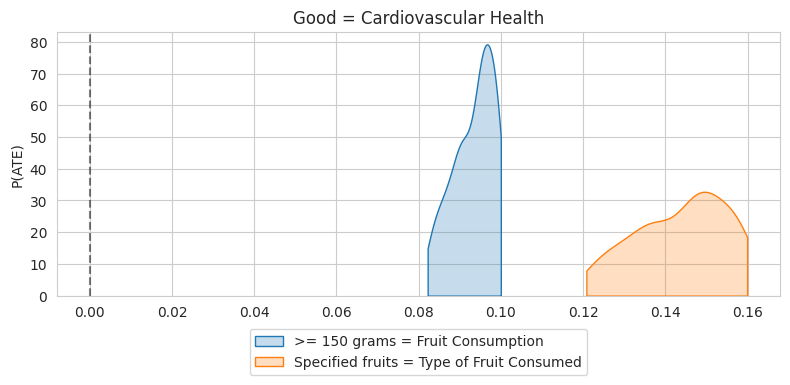

In [15]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{t1vals[1]} = {treatment1}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{t2vals[1]} = {treatment2}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{ovals[1]} = {outcome}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

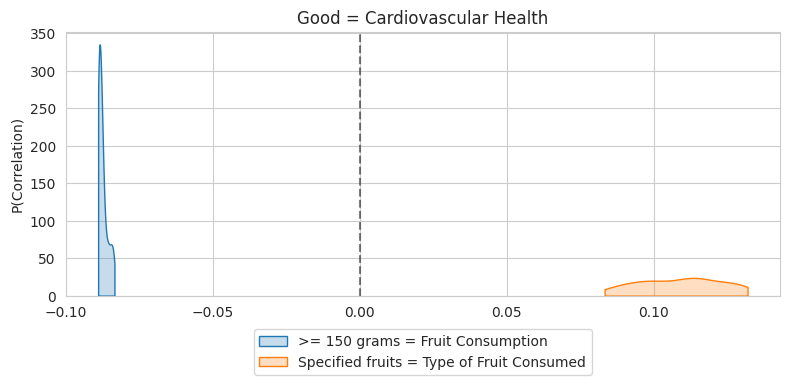

In [16]:
plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{t1vals[1]} = {treatment1}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{t2vals[1]} = {treatment2}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{ovals[1]} = {outcome}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

In [19]:
i = len(list(ctx._root.glob("*.json")))+1
path = ctx._root / f'test{i}'
while path.exists():
    i += 1
    path = ctx._root / f'test{i}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id)

FileExistsError: File /home/fleeb/workspace/code/cladder/novo-data/stories/test14.json already exists (use overwrite=True to overwrite)

In [17]:
mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0

In [18]:
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                    ATE    Correlation  Outcome
-----------------------------------------  -----  -------------  -----------------------------------------
Healthy habits Lifestyle Habits             0.6            0.15  High awareness Health Awareness
Healthy habits Lifestyle Habits             0.55           0.26  >= 150 grams Fruit Consumption
Healthy habits Lifestyle Habits             0             -0     Specified fruits Type of Fruit Consumed
Healthy habits Lifestyle Habits             0.58           0.27  Good Cardiovascular Health
Healthy habits Lifestyle Habits             0.28           0.08  Perceived as Good Perceived Health Status
High awareness Health Awareness             0              0.15  Healthy habits Lifestyle Habits
High awareness Health Awareness             0.28           0.35  >= 150 grams Fruit Consumption
High awareness Health Awareness             0              0     Specified fruits Type of Fruit Consumed
High awareness Health Awa

In [19]:
print(net.backdoor_estimand(treatment1, outcome))
print(net.backdoor_estimand(treatment2, outcome))

('Fruit Consumption', 'Cardiovascular Health', ['Lifestyle Habits'])
('Type of Fruit Consumed', 'Cardiovascular Health', [])


In [20]:
@tool('verbalization_info')
def get_verbalization_info(nodes):
    return tabulate([(node['name'], *node['values'], node['description']) for node in nodes], headers=['Variable Name', 'Value 0', 'Value 1', 'Description'])
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{verbalization_info}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does no smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''
ctx.include(FixedTemplate('verb', verb_prompt_template),);

In [21]:
print(ctx['verb'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {subject} [often/usually/sometimes/rarely/etc.] {value}.
2. There is a [number]% chance that {value}.
3. [number]% of {domain} {value}.
4. [number]% of the time {value}.
5. Conditional sentence: {value}, [some consequence].
6. Interventional: If {value}.

Variable Name            Value 0            Value 1            Description
-----------------------  -----------------  -----------------  -----------------------------------------------------
Lifestyle Habits         Unhealthy habits   Healthy habits     Individual's general lifestyle habits
Health Awareness         Low awareness

In [22]:
#######################################################################


verbalizations = {
    "Lifestyle Habits": {
        "Unhealthy habits": {
            1: {"subject": "people", "value": ["engage in unhealthy lifestyle choices", "follow unhealthy lifestyle practices"]},
            2: {"value": ["an individual follows an unhealthy lifestyle", "someone engages in unhealthy habits"]},
            3: {"domain": "individuals", "value": ["follow unhealthy lifestyles", "practice unhealthy habits"]},
            4: {"value": ["individuals engage in unhealthy lifestyle practices", "people are following unhealthy habits"]},
            5: {"value": ["If a person follows an unhealthy lifestyle", "When someone engages in unhealthy habits"]},
            6: {"value": ["lifestyle habits are unhealthy", "individuals adopt unhealthy habits"]},
        },
        "Healthy habits": {
            1: {"subject": "people", "value": ["lead a healthy lifestyle", "practice healthy living habits"]},
            2: {"value": ["a person leads a healthy lifestyle", "someone practices healthy habits"]},
            3: {"domain": "individuals", "value": ["adopt healthy lifestyles", "embrace healthy living habits"]},
            4: {"value": ["individuals practice healthy lifestyle choices", "people are maintaining healthy habits"]},
            5: {"value": ["If a person leads a healthy lifestyle", "When someone embraces healthy habits"]},
            6: {"value": ["lifestyle habits are healthy", "individuals adopt healthy living practices"]},
        }
    },
    "Health Awareness": {
        "Low awareness": {
            1: {"subject": "people", "value": ["are not well-informed about health matters", "lack health-related knowledge"]},
            2: {"value": ["an individual is not well-informed about health", "someone lacks awareness about health practices"]},
            3: {"domain": "people", "value": ["are not well-informed about health issues", "lack health-related awareness"]},
            4: {"value": ["people show a lack of health awareness", "there is a general lack of health knowledge"]},
            5: {"value": ["If a person is not well-informed about health", "When someone lacks health awareness"]},
            6: {"value": ["health awareness is low", "there is a lack of health-related knowledge"]},
        },
        "High awareness": {
            1: {"subject": "people", "value": ["are well-informed about health matters", "have a high level of health-related knowledge"]},
            2: {"value": ["an individual is well-informed about health", "someone shows high awareness about health practices"]},
            3: {"domain": "people", "value": ["are well-informed about health issues", "have high health-related awareness"]},
            4: {"value": ["people show a high level of health awareness", "there is widespread health knowledge"]},
            5: {"value": ["If a person is well-informed about health", "When someone has high health awareness"]},
            6: {"value": ["health awareness is high", "there is a widespread understanding of health-related issues"]},
        }
    },
    "Fruit Consumption": {
        "< 150 grams": {
            1: {"subject": "people", "value": ["consume a small amount of fruit", "do not eat much fruit"]},
            2: {"value": ["an individual consumes less fruit", "someone eats a minimal amount of fruit"]},
            3: {"domain": "people", "value": ["consume limited fruit", "eat less than the recommended amount of fruit"]},
            4: {"value": ["fruit consumption is minimal", "there is a low intake of fruit"]},
            5: {"value": ["If a person consumes a small amount of fruit", "When someone does not eat much fruit"]},
            6: {"value": ["fruit consumption is below the recommended level", "people do not eat enough fruit"]},
        },
        ">= 150 grams": {
            1: {"subject": "people", "value": ["consume a significant amount of fruit", "eat plenty of fruit"]},
            2: {"value": ["an individual consumes more fruit", "someone eats a substantial amount of fruit"]},
            3: {"domain": "people", "value": ["consume a good amount of fruit", "eat the recommended amount of fruit or more"]},
            4: {"value": ["fruit consumption is substantial", "there is a high intake of fruit"]},
            5: {"value": ["If a person consumes a significant amount of fruit", "When someone eats plenty of fruit"]},
            6: {"value": ["fruit consumption meets or exceeds the recommended level", "people eat a healthy amount of fruit"]},
        }
    },
    "Type of Fruit Consumed": {
        "Other fruits": {
            1: {"subject": "people", "value": ["opt for a variety of fruits", "choose fruits other than the specified ones"]},
            2: {"value": ["an individual prefers different fruits", "someone chooses a range of fruits"]},
            3: {"domain": "people", "value": ["select a broad range of fruits", "choose various fruits"]},
            4: {"value": ["a variety of fruits are consumed", "there is a preference for diverse fruits"]},
            5: {"value": ["If a person opts for a variety of fruits", "When someone chooses fruits other than the specified ones"]},
            6: {"value": ["a broad range of fruits is consumed", "there is a preference for different fruits"]},
        },
        "Specified fruits": {
            1: {"subject": "people", "value": ["prefer the specified fruits", "choose the particular fruits mentioned"]},
            2: {"value": ["an individual opts for the specified fruits", "someone selects the particular fruits"]},
            3: {"domain": "people", "value": ["choose the specified fruits", "select the particular fruits mentioned"]},
            4: {"value": ["the specified fruits are consumed", "there is a preference for the particular fruits"]},
            5: {"value": ["If a person prefers the specified fruits", "When someone chooses the particular fruits mentioned"]},
            6: {"value": ["the specified fruits are preferred", "people opt for the particular fruits"]},
        }
    },
    "Cardiovascular Health": {
        "Poor": {
            1: {"subject": "people", "value": ["have poor cardiovascular health", "suffer from cardiovascular issues"]},
            2: {"value": ["an individual has poor cardiovascular health", "someone suffers from heart-related problems"]},
            3: {"domain": "people", "value": ["suffer from poor cardiovascular health", "experience heart-related issues"]},
            4: {"value": ["cardiovascular health is compromised", "there are prevalent cardiovascular problems"]},
            5: {"value": ["If a person has poor cardiovascular health", "When someone suffers from cardiovascular issues"]},
            6: {"value": ["cardiovascular health is not optimal", "there are widespread heart-related problems"]},
        },
        "Good": {
            1: {"subject": "people", "value": ["enjoy good cardiovascular health", "have a strong heart and healthy blood vessels"]},
            2: {"value": ["an individual enjoys good cardiovascular health", "someone has a strong heart"]},
            3: {"domain": "people", "value": ["benefit from good cardiovascular health", "have strong hearts and healthy blood vessels"]},
            4: {"value": ["cardiovascular health is robust", "there is a high level of heart health"]},
            5: {"value": ["If a person enjoys good cardiovascular health", "When someone has a strong heart"]},
            6: {"value": ["cardiovascular health is in a good state", "people have healthy hearts and blood vessels"]},
        }
    },
    "Perceived Health Status": {
        "Perceived as Poor": {
            1: {"subject": "individuals", "value": ["feel their health is not in the best shape", "perceive their health negatively"]},
            2: {"value": ["an individual perceives their health as poor", "someone views their own health unfavorably"]},
            3: {"domain": "people", "value": ["feel their health is poor", "view their health negatively"]},
            4: {"value": ["individuals feel their health is poor", "people view their health negatively"]},
            5: {"value": ["If someone perceives their health as poor", "When an individual has a negative view of their health"]},
            6: {"value": ["the perception of health is poor", "individuals view their health unfavorably"]}
        },
        "Perceived as Good": {
            1: {"subject": "individuals", "value": ["feel they are in good health", "perceive their health positively"]},
            2: {"value": ["an individual perceives their health as good", "someone views their own health favorably"]},
            3: {"domain": "people", "value": ["feel they are in good health", "view their health positively"]},
            4: {"value": ["individuals feel they are in good health", "people view their health positively"]},
            5: {"value": ["If someone perceives their health as good", "When an individual has a positive view of their health"]},
            6: {"value": ["the perception of health is good", "individuals view their health favorably"]}
        }
    }
}


#######################################################################
ctx['verbalizations'] = verbalizations

In [23]:
quantity_template = ''''''

In [24]:
ctx['treatments']

[{'name': 'Fruit Consumption',
  'description': 'Consumption of fruits weekly',
  'type': 'treatment',
  'observed': True,
  'values': ['< 150 grams', '>= 150 grams'],
  'parents': ['Lifestyle Habits', 'Health Awareness']},
 {'name': 'Type of Fruit Consumed',
  'description': 'Type of fruits consumed, specified or others',
  'type': 'treatment',
  'observed': True,
  'values': ['Other fruits', 'Specified fruits'],
  'parents': []}]

In [47]:
# ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
ate_tmpl = '{val:.3f} = ATE({treatment}) = E({outcome} | do({treatment}=1)) - E({outcome} | do({treatment}=0))'
cate_tmpl = ('{val:.3f} = CATE({treatment} | {confounder}={cval}) = '
             'E[{outcome} | {confounder}={cval}, do({treatment}=1)] - E[{outcome} | {confounder}={cval}, do({treatment}=0)]')

In [52]:
for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
    print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
    print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

0.093 = ATE(Fruit Consumption) = E(Cardiovascular Health | do(Fruit Consumption=1)) - E(Cardiovascular Health | do(Fruit Consumption=0))
0.144 = ATE(Type of Fruit Consumed) = E(Cardiovascular Health | do(Type of Fruit Consumed=1)) - E(Cardiovascular Health | do(Type of Fruit Consumed=0))
0.100 = CATE(Fruit Consumption | Lifestyle Habits=0) = E[Cardiovascular Health | Lifestyle Habits=0, do(Fruit Consumption=1)] - E[Cardiovascular Health | Lifestyle Habits=0, do(Fruit Consumption=0)]
0.088 = CATE(Fruit Consumption | Lifestyle Habits=1) = E[Cardiovascular Health | Lifestyle Habits=1, do(Fruit Consumption=1)] - E[Cardiovascular Health | Lifestyle Habits=1, do(Fruit Consumption=0)]
0.200 = CATE(Type of Fruit Consumed | Lifestyle Habits=0) = E[Cardiovascular Health | Lifestyle Habits=0, do(Type of Fruit Consumed=1)] - E[Cardiovascular Health | Lifestyle Habits=0, do(Type of Fruit Consumed=0)]
0.081 = CATE(Type of Fruit Consumed | Lifestyle Habits=1) = E[Cardiovascular Health | Lifestyle Hab

In [29]:
SimpleTemplater(cate_tmpl).fill_in({}, ate2=ate2.mean().item())

"0.144 = ATE('Type of Fruit Consumed') = P('Cardiovascular Health'='Good' | do('Type of Fruit Consumed'='Specified fruits')) - P('Cardiovascular Health'='Good' | do('Type of Fruit Consumed'='Other fruits'))"

In [ ]:
print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [26]:
tmpl = FixedTemplate('', ate1_template)
tmpl.keys

{'ate1', 'outcome', 'treatments'}

In [27]:
tmpl.grab_from(ctx, '')

"ATE('Fruit Consumption') = P('Cardiovascular Health'='Good' | do('Fruit Consumption'='>= 150 grams')) - P('Cardiovascular Health'='Good' | do('Fruit Consumption'='< 150 grams')) = 0.09"

In [ ]:
ate_def = 'ATE(treatment) = P(outcome | do(treatment=1)) - P(outcome | do(treatment=0))'
cate_def = 'CATE(treatment | confounder=c) = E[outcome | confounder=c, do(treatment1=1)] - E[outcome | confounder=c, do(treatment1=0)]'

In [26]:
mn1, mx1 = ate1.min().item(), ate1.max().item()
mn2, mx2 = ate2.min().item(), ate2.max().item()
mn1, mx1, mn2, mx2

In [ ]:
net.ate(treatment1)[outcome].item()

In [ ]:
question_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

Now we would like to use this model to generate some interesting research questions:

1. Write a short two sentence introduction to describe motivation and purpose of the causal model to provide context to the questions in an conversational/debate setting. Where possible, include relevant details from the original article headline. Avoid discussing specific structural properties or assumptions in the causal graph, and instead focus on the overall motivation and potential applications for the model. 
Make sure not to use and technical terms from causal inference so that the introduction is easy to understand even for a layperson.
2. Write a short two sentence overview of the structure of the causal graph including noteworthy properties and assumptions. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "confounder"/"confounding", "mediator"/"mediates") as long as you explain them in a way that is understandable to a layperson.
3. Come up with ten interesting "yes"/"no" questions where the correct answer depends computation of exactly one of the following quantities: ['ATE()]


involves either the sign of the ATE of either treatment variable or some comparison between the ATEs of the two treatments. Make sure to formulate the question in an intuitive, yet precise manner and so that the correct answer is either "yes" or "no". Include the correct answer, and a brief 1 sentence explanation. Most importantly, include the formal ineqality that must be computed to get the correct answer ("yes"=True, "no"=False) (for example, if the ATE of treatment variable "A" is greater than the ATE of treatment variable "B", and the correct answer is "yes" and the inequality is "ATE(A) > ATE(B)", or if the question asks whether treatment variable "A" has a positive causal effect on the outcome variable, then the inequality is "ATE(A) > 0"). Make sure the questions are intuitive and easy to understand even for a layperson, but not trivial.

Answer in the form of a python dictionary in the following format:

```python
setting = {
  "introduction": "[introduction]",
  "overview": "[overview]",
  "questions": {
    1: {"question": "[question]", "answer": "yes", "explanation": "[explanation]", "inequality": "ATE(A) > 0"},
    ...
  },
}
```

Answer concisely and precisely in the desired format, without any additional comments or discussion.


Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{verbalization_info}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does no smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args